In [85]:
import numpy             as     np
import math
import matplotlib.pyplot as     plt
from   hyperfit.linfit   import LinFit
from   astropy.table     import Table
from   astropy.cosmology import FlatLambdaCDM
from   matplotlib.pyplot import cm
import matplotlib
from   scipy.special     import gamma
from   scipy             import interpolate
from   scipy             import stats

import pickle
import time
import progressbar
from   useful_functions  import *

#For making multiple page pdfs
from matplotlib.backends.backend_pdf import PdfPages

In [86]:
# _________________________________________________________
# _________________________________________________________
# -- Import files -- #
#                                       ... must always run
# _________________________________________________________

#First import the catalogue into an astropy.table (This is the catalogue I made with physical units included)
print('Reading in catalogues...')

#Path where all the files are for this/ where this code is located
path = '/home/jenniferhardwick/Insync/21514305@student.uwa.edu.au/OneDrive Biz/PhD/Project2_codes/'

#-------
#-------
#Switch to True or False depending if you want to have MW Extinction
MW_Extinction_On = True
#-------
#-------

# --
#Loading files from "BuildingProfiles_of_xGASS.ipynb"
if MW_Extinction_On:
    mydata = Table.read('/home/jenniferhardwick/Insync/21514305@student.uwa.edu.au/OneDrive Biz/PhD/xGASS_Decomposition_Catalogue/Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL+MWExtinction_v3.fits')
else:
    mydata = Table.read('/home/jenniferhardwick/Insync/21514305@student.uwa.edu.au/OneDrive Biz/PhD/xGASS_Decomposition_Catalogue/Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL_v3.fits')
    
# -- For some reason it imports strings as 'byte10' instead, so convert them to strings:
key = mydata.keys() 
for idx in range(len(key)):
    if mydata.dtype[idx] == object:
        mydata[key[idx]] = mydata[key[idx]].str.decode("utf-8")

#--
        
print('Catalogues loaded')

#Define our cosmology to be flat with the following values.
cosmo = FlatLambdaCDM(H0=70,Om0=0.3,Tcmb0 = 2.725)

Reading in catalogues...
Catalogues loaded


In [87]:
# _________________________________________________________
# _________________________________________________________
# -- Import Obreschkow+2016 data -- #
#                                       ... must always run
# _________________________________________________________

#f = open(path+'Catalogues/obreschkow2016.txt', 'r')
#print(f.read()) 

O16_source = []
O16_lgfatm = []
O16_lgq = []

i = 0
with open(path+'Catalogues/obreschkow2016.txt', 'r') as infile:
    for line in infile:
        if i < 5:
            pass
        elif line.split()[0] == 'GASS':
                pass
        else:
            O16_source.append(line.split()[0])
            O16_lgfatm.append(float(line.split()[2]))
            O16_lgq.append(float(line.split()[3]))
        i +=1
        
O16_source = np.array(O16_source)
O16_lgfatm = np.array(O16_lgfatm)
O16_lgq = np.array(O16_lgq)

In [88]:
# _________________________________________________________
# _________________________________________________________
# -- Loading xCOLD GASS data set for H2 -- #
#                                       ... must always run
# _________________________________________________________

#--
#Loading files from the xCOLD GASS public database

xCOLD_GASS = Table.read(path+'Catalogues/xCOLDGASS_PubCat.fits')

order_mydata = []
order_xCOLD_GASS = []
for i,GASSID in enumerate(xCOLD_GASS['ID']): #For every id in Mydata
    loc = np.argwhere(mydata['GASSID'] == ('GASS'+str(GASSID)))
    #First test if the xCOLD_GASS ID exists in my catalogue
    if len(loc) == 0:
        pass
    else:
        #If it exists, then we are only interested in the galaxies meeting our selection requirement\
        if (mydata['i'][loc[0][0]] > 30) & (mydata['HIconf_flag'][loc[0][0]] == 0):
            order_mydata.append(loc[0][0]) #find that ID in repsample and record its location  
            order_xCOLD_GASS.append(i)     #Record that ID as one that we will study

In [89]:
i = mydata['i']

Model = mydata['Model'] # 0  = 2 component
                        # 1  = pure disk
                        # 2  = pure bulge
                        # -1 = no fit possible

HI = mydata['HIconf_flag'] # 0        = HI Detected no confusion, 
                           # 1        = HI detected and definite confusion
                           # 0<flag<1 = HI detected and possible confusion
                           # -99      = HI not detected

In [124]:
import scipy

def sudo_sersic(r,n,a):
    bn =  2*n - 1/3 + 0.009876/n
    return a*np.exp(-bn*r**(1./n))

r_RHI  = np.array([0.100000,0.200000,0.300000,0.400000,0.500000,0.600000,0.700000,0.800000,0.900000,1.00000,1.10000 ,1.20000 ,1.3]) #r/R_HI
Sig_HI= np.array([5.50455 ,5.82575 ,5.47971 ,5.21774 ,4.42226 ,3.56687 ,2.69376 ,2.04850 ,1.45364 ,1.00281,0.643707,0.368113,0.2]) #Msun/pc^2

popt, pcov = scipy.optimize.curve_fit(sudo_sersic,r_RHI,Sig_HI)

[0.86854866 7.02150141]


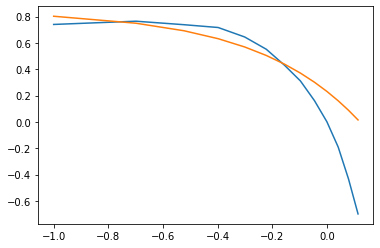

In [133]:
print(popt)
plt.plot(np.log10(r_RHI),np.log10(Sig_HI))
plt.plot(np.log10(r_RHI),np.log10(sudo_sersic(r_RHI,popt[0],popt[1])))

In [61]:
# _________________________________________________________
# _________________________________________________________
# -- Determine j_{HI} -- #
# _________________________________________________________

#here is the median HI profile sent by Jing Wang, (Wang+2016).
#The data points are radius in units of R_HI (r/R_HI) and HI mass surface density in Msun/pc^2 (you might want to plot this as log):

r_RHI  = np.array([0.100000,0.200000,0.300000,0.400000,0.500000,0.600000,0.700000,0.800000,0.900000,1.00000,1.10000 ,1.20000 ,1.3]) #r/R_HI
Sig_HI= np.array([5.50455 ,5.82575 ,5.47971 ,5.21774 ,4.42226 ,3.56687 ,2.69376 ,2.04850 ,1.45364 ,1.00281,0.643707,0.368113,0.2]) #Msun/pc^2

#From Wang+2016
#R_HI = 0.5 DHI
#log10(D_HI) = (0.506 ± 0.003) log10(M_HI) − (3.293 ± 0.009), #D_HI [kpc], M_HI [Msun]

rHI = []
mydata['j_HI'] = np.zeros(len(mydata['GASSID']))

for indx in range(len(mydata['GASSID'])):
    D_HI = 10**(0.506*mydata['lgMHI'][indx]-3.293) #[kpc]
    R_HI = 0.5*D_HI #[kpc]
    r_kpc = r_RHI*R_HI #[kpc]
    
    mydata['j_HI'][indx] = TotalSpecificAM(r_kpc,Sig_HI,ConstantV(r_kpc,mydata['rot_velocity'][indx])) #[kpc.km.s^-1]
    
    rHI.append(r_kpc[-1])
    
Re10 = 10*mydata['re_r_kpc']
rHI = np.array(rHI)

mydata['HIradius_kpc'] = rHI

/home/jenniferhardwick/Insync/21514305@student.uwa.edu.au/OneDrive Biz/PhD/Project2_codes/useful_functions.py:41: RuntimeWarning: Mean of empty slice
  return np.nansum(np.nanmean([Func[i],Func[i+one]])*(R[i+one]-R[i]))


[-6.98897523  0.10491162]


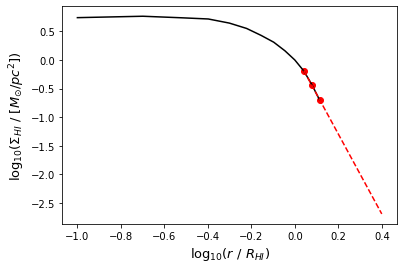

In [62]:
plt.plot(np.log10(r_RHI),np.log10(Sig_HI),color='k')
plt.xlabel('$\log_{10}(r \ / \ R_{HI})$',fontsize=13)
plt.ylabel('$\log_{10}(\Sigma_{HI} \ / \ [M_{\odot} / pc^{2}] )$',fontsize=13)
plt.savefig(path+'Figures/HISurfaceDensityProfile.pdf')

plt.scatter(np.log10(r_RHI)[-3:],np.log10(Sig_HI)[-3:],color='r')
coef = np.polyfit(np.log10(r_RHI)[-3:],np.log10(Sig_HI)[-3:],1)
print(coef)
poly1d_fn = np.poly1d(coef)
plt.plot([np.log10(r_RHI)[-3],0.4],poly1d_fn([np.log10(r_RHI)[-3],0.4]),color='r',ls='--')
plt.savefig(path+'Figures/HISurfaceDensityProfile_Extrapolate.pdf')

0.48753424060737954


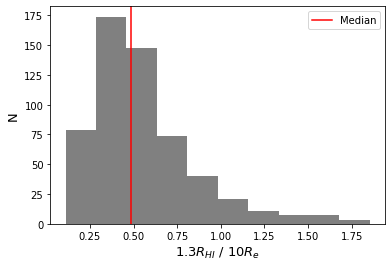

In [63]:
plt.figure()
plt.hist(rHI[(i>30)&(HI==0)]/Re10[(i>30)&(HI==0)],color='grey')
plt.axvline(np.median(rHI[(i>30)&(HI==0)]/Re10[(i>30)&(HI==0)]),color='r',label='Median')
print(np.median(rHI[(i>30)&(HI==0)]/Re10[(i>30)&(HI==0)]))
plt.xlabel('$1.3R_{HI} \ / \ 10R_{e}$',fontsize=13)
plt.ylabel('N',fontsize=13)
plt.legend()
plt.savefig(path+'Figures/CompareR_e&R_HI.pdf')

In [64]:
# _________________________________________________________
# _________________________________________________________
# -- Determine j_{HI} -- #
# _________________________________________________________

#here is the median HI profile sent by Jing Wang, (Wang+2016).
#The data points are radius in units of R_HI (r/R_HI) and HI mass surface density in Msun/pc^2 (you might want to plot this as log):

r_RHI  = np.array([0.100000,0.200000,0.300000,0.400000,0.500000,0.600000,0.700000,0.800000,0.900000,1.00000,1.10000 ,1.20000 ,1.3]) #r/R_HI
Sig_HI= np.array([5.50455 ,5.82575 ,5.47971 ,5.21774 ,4.42226 ,3.56687 ,2.69376 ,2.04850 ,1.45364 ,1.00281,0.643707,0.368113,0.2]) #Msun/pc^2

#From Wang+2016
#R_HI = 0.5 DHI
#log10(D_HI) = (0.506 ± 0.003) log10(M_HI) − (3.293 ± 0.009), #D_HI [kpc], M_HI [Msun]

for r in np.arange(1.4,10,0.01):
    r_RHI = np.append(r_RHI,r)
    Sig_HI = np.append(Sig_HI,coef[1]*r**coef[0])

rHI = []
mydata['j_HI_Re10'] = np.zeros(len(mydata['GASSID']))

Re10 = 10*mydata['re_r_kpc']

for indx in range(len(mydata['GASSID'])):
    D_HI = 10**(0.506*mydata['lgMHI'][indx]-3.293) #[kpc]
    R_HI = 0.5*D_HI #[kpc]
    r_kpc = r_RHI*R_HI #[kpc]
    
    mydata['j_HI_Re10'][indx] = TotalSpecificAM(r_kpc[r_kpc<=Re10[indx]],Sig_HI[r_kpc<=Re10[indx]],ConstantV(r_kpc[r_kpc<=Re10[indx]],mydata['rot_velocity'][indx])) #[kpc.km.s^-1]
    
    rHI.append(r_kpc[-1])
    
rHI = np.array(rHI)

mydata['HIradius_kpc'] = rHI

/home/jenniferhardwick/Insync/21514305@student.uwa.edu.au/OneDrive Biz/PhD/Project2_codes/useful_functions.py:41: RuntimeWarning: Mean of empty slice
  return np.nansum(np.nanmean([Func[i],Func[i+one]])*(R[i+one]-R[i]))


In [65]:
# _________________________________________________________
# _________________________________________________________
# -- Determine M_{H2}, fatm & q -- #
# _________________________________________________________

#f_atm = (1.35 * M_{HI}) / M
#M = (M_{*} + 1.35*M_{HI} + M_{H2})

#q = (j \sigma) / GM

#---------
#---------

M_HI   = 10**mydata['lgMHI']

#--------

M_star  = [] #Disk Stellar Mass
Re_r_pc = [] #Half-light radius in the r-band (in pc) 
j_star  = [] 
for ii,m in enumerate(mydata['Model']):
    if m ==  0:
        M_star.append(10**mydata['TotMstar_recover_fixD'][ii])
        Re_r_pc.append(mydata['reT_r_kpc'][ii]*1000)
        j_star.append(mydata['j_mustar_10Re_brD'][ii])
    elif m == 1:
        M_star.append(10**mydata['TotMstar_recover_fix'][ii])
        Re_r_pc.append(mydata['re_r_kpc'][ii]*1000)
        j_star.append(mydata['j_mustar_10Re_brT'][ii])
    elif m == 2:
        #Because we only want the disk mass, we will ignore pure bulges
        M_star.append(0)
        Re_r_pc.append(mydata['re_r_kpc'][ii]*1000)
        j_star.append(0)
    else:
        M_star.append(float('nan'))
        Re_r_pc.append(float('nan'))
        j_star.append(float('nan'))
        
M_star  = np.array(M_star) 
Re_r_pc = np.array(Re_r_pc)
j_star  = np.array(j_star) 

#--------



M_H2 = [] #H2 Mass
M_H2_upplim = []
detect_flag = [] # 0 = detection, 1 = lower limit, 2 = estimate
for ii,g in enumerate(mydata['GASSID']):
    loc = np.argwhere(xCOLD_GASS['ID'] == int(g[4:]))
    if len(loc) != 0:
        if xCOLD_GASS['LOGMH2'][loc] !=0.0:
            M_H2.append(10**xCOLD_GASS['LOGMH2'][loc][0][0])
            M_H2_upplim.append(float('nan'))
            detect_flag.append(0)
        elif xCOLD_GASS['LIM_LOGMH2'][loc]!=0:
            M_H2.append(10**(0.94215579*(np.log10(mydata['SFR'][ii])-np.log10(np.pi*Re_r_pc[ii]**2)) + 8.60739493 + np.log10(np.pi*Re_r_pc[ii]**2) ) ) #old method: 10**(1.08817*np.log10(mydata['SFR'][ii])+9.07264)
            M_H2_upplim.append(10**xCOLD_GASS['LIM_LOGMH2'][loc][0][0])
            detect_flag.append(1)
        else:
            print('oh no')
    elif HI[ii] ==0:
        if mydata['SFR'][ii] != -99:
            M_H2.append( 10**(0.94215579*(np.log10(mydata['SFR'][ii])-np.log10(np.pi*Re_r_pc[ii]**2)) + 8.60739493 + np.log10(np.pi*Re_r_pc[ii]**2) ) ) #old method: 10**(1.08817*np.log10(mydata['SFR'][ii])+9.07264)
            M_H2_upplim.append(float('nan'))
        else:
            print(g)
            M_H2.append(0.2*M_HI[ii])
            M_H2_upplim.append(float('nan'))
        detect_flag.append(2)
    else:
        M_H2.append(float('nan'))
        M_H2_upplim.append(float('nan'))
        detect_flag.append(3)
M_H2        = np.array(M_H2)
M_H2_upplim = np.array(M_H2_upplim)
detect_flag = np.array(detect_flag)

#--------

#This is the fraction of atomic gas which is the lower limit, as we use H_{2} upper limits.
M = M_star + (1.35*M_HI) + M_H2 #Baryonic mass in stellar masses
fatm = 1.35*M_HI / M #Unit-less fraction

#For galaxies were we are using a H_{2} upper limit, we can also get an upper limit of f_atm by assuming the lower limit of H_{2} -> that there is none.
fatm_up = []
for ii,d in enumerate(detect_flag):
    if d == 1:
        fatm_up.append((1.35*M_HI[ii]) / (M_star[ii] + 1.35*(M_HI[ii])))
    else:
        fatm_up.append(fatm[ii])

G = 4.3009125*10**(-6) #kpc (km.s^-1)^2 M_{\odot}^-1

sig = 10 #km.s^-1 #assumed to be constant

j_HI = mydata['j_HI']

j = (j_star*(M_star+M_H2) + 1.35*j_HI*M_HI)/M #j baryon

q = (j*sig)/(G*M) #unit-less

#--------
print(np.log10(G) - (1/1.12)*np.log10(2.5) - np.log10(sig))
#--------

mydata['M_H2']            = M_H2        # H_{2} mass from either a detection or approximation (see "H2_flag" so distinguishing between types)
mydata['LIM_M_H2']        = M_H2_upplim # H_{2} upper limit (if observed but not detected, otherwise NaN)
mydata['H2_flag']         = detect_flag # 0 = detection, 1 = Approximation (only upper limit avail.), 2 = Approximation (no xCOLD GASS), 3 = no HI to determine approximation
mydata['M_baryon_D']      = M           # M = M_{*,D} + 1.35M_{HI} + M_{H2}
mydata['j_baryon_1.3RHI'] = j           # j = (j_star*M_star + j_HI*M_HI)/(M_star + M_HI)
mydata['q_1.3RHI']        = q           # q = (j \sigma) / GM
mydata['fatm_D']          = fatm        # f_atm = (1.35 * M_{HI}) / M
mydata['fatm_up']         = fatm_up     #upper limit of fatm

#--------

j_HI = mydata['j_HI_Re10']

j = (j_star*(M_star+M_H2) + 1.35*j_HI*M_HI)/M #j baryon

q = (j*sig)/(G*M) #unit-less

mydata['j_baryon_D'] = j           
mydata['q_D']        = q           # q = (j \sigma) / GM


#-------


M_star_tot = [] #Stellar Mass
for ii,m in enumerate(mydata['Model']):
    if m ==  0:
        M_star_tot.append(10**mydata['TotMstar_recover_fixT'][ii])
    elif m == 1:
        M_star_tot.append(10**mydata['TotMstar_recover_fix'][ii])
    elif m == 2:
        M_star_tot.append(10**mydata['TotMstar_recover_fix'][ii])
    else:
        M_star_tot.append(float('nan'))
M_star_tot = np.array(M_star_tot) 

M_bar_tot = M_star_tot + (1.35*M_HI) + M_H2   
j_bar_tot = (mydata['j_mustar_10Re_brT']*(M_star_tot+M_H2) + 1.35*mydata['j_HI_Re10']*M_HI)/M_bar_tot

mydata['M_baryon_T'] = M_bar_tot           # M = M_{*,D} + 1.35M_{HI} + M_{H2}
mydata['j_baryon_T'] = j_bar_tot  



mydata.write(path+'Catalogues/xGASS_Decomposition_Catalogue_PHYSICAL+MWExtinction_v4.fits',overwrite=True)

<ipython-input-65-d663a105bfd6>:59: RuntimeWarning: invalid value encountered in log10
  M_H2.append(10**(0.94215579*(np.log10(mydata['SFR'][ii])-np.log10(np.pi*Re_r_pc[ii]**2)) + 8.60739493 + np.log10(np.pi*Re_r_pc[ii]**2) ) ) #old method: 10**(1.08817*np.log10(mydata['SFR'][ii])+9.07264)


GASS123007
GASS38198
-6.7217429720402295


In [66]:
i = mydata['i']

Model = mydata['Model'] # 0  = 2 component
                        # 1  = pure disk
                        # 2  = pure bulge
                        # -1 = no fit possible

HI = mydata['HIconf_flag'] # 0        = HI Detected no confusion, 
                           # 1        = HI detected and definite confusion
                           # 0<flag<1 = HI detected and possible confusion
                           # -99      = HI not detected

In [67]:
##--------------------------------------------------------------------
##-- If H_2 was not included in any of the M_bar or j_bar calculations
##--------------------------------------------------------------------

In [68]:
M_bar_excl_H2 = M_star + (1.35*M_HI)
j_bar_excl_H2 = (j_star*(M_star) + 1.35*j_HI*M_HI)/M_bar_excl_H2

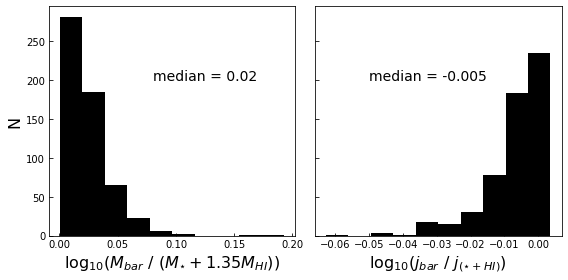

In [69]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(8,4),sharey=True)

ax[0].hist(np.log10(mydata['M_baryon_D'][(i>30)&(HI==0)]) - np.log10(M_bar_excl_H2[(i>30)&(HI==0)]),color='k')
ax[0].text(0.08,200,'median = '+str(round(np.nanmedian(np.log10(mydata['M_baryon_D'][(i>30)&(HI==0)]) - np.log10(M_bar_excl_H2[(i>30)&(HI==0)])),3)),fontsize=14)

ax[0].set_xlabel('$\log_{10}(M_{bar}\ / \ (M_{\star}+1.35M_{HI}))$',fontsize=16)
ax[0].set_ylabel('N',fontsize=16)

ax[1].hist(np.log10(mydata['j_baryon_D'][(i>30)&(HI==0)]) - np.log10(j_bar_excl_H2[(i>30)&(HI==0)]),color='k')
ax[1].text(-0.05,200,'median = '+str(round(np.nanmedian(np.log10(mydata['j_baryon_D'][(i>30)&(HI==0)]) - np.log10(j_bar_excl_H2[(i>30)&(HI==0)])),3)),fontsize=14)

ax[1].set_xlabel('$\log_{10}(j_{bar}\ / \ j_{(\star + HI)})$',fontsize=16)

ax[0].tick_params(direction='in')
ax[1].tick_params(direction='in')
fig.tight_layout()

fig.savefig('/home/jenniferhardwick/Insync/21514305@student.uwa.edu.au/OneDrive Biz/PhD/Thesis_Files/excludingMH2.pdf')

In [70]:
##--------------------------------------------------------------------
##-- ERRORS BY TAKING MAX AND MIN VALUES
##--------------------------------------------------------------------

M_bar median error = +/- 0.13324621957453475


<ipython-input-71-529119062a50>:11: RuntimeWarning: divide by zero encountered in log10
  M_star_max = 10**(np.log10(M_star) + 0.15)
<ipython-input-71-529119062a50>:12: RuntimeWarning: divide by zero encountered in log10
  M_star_min = 10**(np.log10(M_star) - 0.15)


(array([  5.,   9.,  24.,  39.,  53.,  58.,  77.,  92., 109.,  98.]),
 array([0.16881314, 0.18222708, 0.19564102, 0.20905496, 0.2224689 ,
        0.23588284, 0.24929679, 0.26271073, 0.27612467, 0.28953861,
        0.30295255]),
 <BarContainer object of 10 artists>)

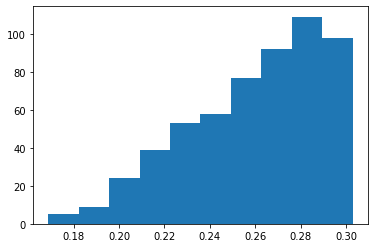

In [71]:

#  M_bar = M_star + M_mol + 1.35 M_HI

# M_mol has an log10(M_H2_error) of 0 to 0.22 with a median of 0.17 (a column in the xCOLD GASS catalogue) -> I think assuming 0.17 is reasonable (doesn't really matter as H_2 contributes so little)
# M_star has an error of ~0.15 dex from the light-to-mass conversion in Zibetti+2009
#M_HI has an error of ??


M_H2_max = 10**(np.log10(M_H2) + 0.17)
M_H2_min = 10**(np.log10(M_H2) - 0.17)

M_star_max = 10**(np.log10(M_star) + 0.15)
M_star_min = 10**(np.log10(M_star) - 0.15)

M_HI_max = 10**(np.log10(M_HI) + 0.08)
M_HI_min = 10**(np.log10(M_HI) - 0.08)

M_bar_max = M_star_max + M_H2_max + 1.35*M_HI_max
M_bar_min = M_star_min + M_H2_min + 1.35*M_HI_min

print('M_bar median error = +/-',np.nanmedian(np.log10(M_bar_max[(i>30)&(HI==0)])-np.log10(M_bar_min[(i>30)&(HI==0)]))/2.)
plt.hist(np.log10(M_bar_max[(i>30)&(HI==0)])-np.log10(M_bar_min[(i>30)&(HI==0)]))

j_bar median error = +/- 0.2848169933892516


<ipython-input-72-0bb8a14dc380>:9: RuntimeWarning: divide by zero encountered in log10
  j_star_max = 10**(np.log10(j_star) + 0.01)
<ipython-input-72-0bb8a14dc380>:10: RuntimeWarning: divide by zero encountered in log10
  j_star_min = 10**(np.log10(j_star) - 0.01)
<ipython-input-72-0bb8a14dc380>:12: RuntimeWarning: divide by zero encountered in log10
  j_HI_max = 10**(np.log10(j_HI) + 0.06)
<ipython-input-72-0bb8a14dc380>:13: RuntimeWarning: divide by zero encountered in log10
  j_HI_min = 10**(np.log10(j_HI) - 0.06)


(array([  6.,  14.,  28.,  57.,  55.,  68.,  71.,  82., 113.,  70.]),
 array([0.448813  , 0.46666872, 0.48452443, 0.50238014, 0.52023585,
        0.53809157, 0.55594728, 0.57380299, 0.5916587 , 0.60951442,
        0.62737013]),
 <BarContainer object of 10 artists>)

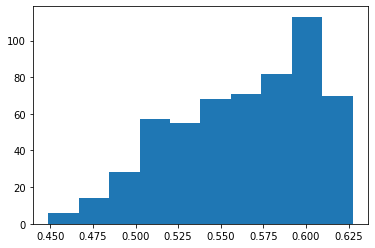

In [72]:
#j = (j_star*(M_star+M_H2) + 1.35*j_HI*M_HI)/M_bar

#M_bar error given above

#j_star error in paper 1 had a median error of 0.01 dex

#j_HI had a median error of \pm 0.06 dex

j_star_max = 10**(np.log10(j_star) + 0.01)
j_star_min = 10**(np.log10(j_star) - 0.01)

j_HI_max = 10**(np.log10(j_HI) + 0.06)
j_HI_min = 10**(np.log10(j_HI) - 0.06)

j_bar_max = (j_star_max*(M_star_max+M_H2_max) + 1.35*j_HI_max*M_HI_max)/M_bar_min
j_bar_min = (j_star_min*(M_star_min+M_H2_min) + 1.35*j_HI_min*M_HI_min)/M_bar_max

print('j_bar median error = +/-',np.nanmedian(np.log10(j_bar_max[(i>30)&(HI==0)])-np.log10(j_bar_min[(i>30)&(HI==0)]))/2.)
plt.hist(np.log10(j_bar_max[(i>30)&(HI==0)])-np.log10(j_bar_min[(i>30)&(HI==0)]))

In [73]:
##--------------------------------------------------------------------
##-- ERRORS BY PROPOGATION
##--------------------------------------------------------------------

In [74]:
M_bar = M_star + (1.35*M_HI) + M_H2

sig_Mstar = np.log(10)*M_star*0.15 #From Zibetti+2009
sig_MH2   = np.log(10)*M_H2  *0.17 #From xCOLD GASS catalogue
sig_MHI   = np.log(10)*M_HI  *0.08 #From personal correspondence with Barbara

sig_Mbar  = np.sqrt( sig_Mstar**2 + sig_MH2**2 + (1.35*sig_MHI)**2 ) 
dex_Mbar  = (sig_Mbar)/(np.log(10)*M_bar)

M_bar median error = +/- 0.10543667531661324


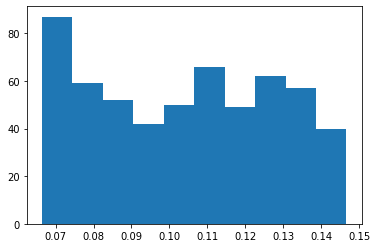

In [75]:
plt.hist(dex_Mbar[(i>30)&(HI==0)])
print('M_bar median error = +/-',np.nanmedian(dex_Mbar[(i>30)&(HI==0)]))


In [76]:
sig_jstar = np.log(10)*j_star*0.01 #From MCMC chain of hyperfit
sig_jHI   = np.log(10)*j_HI*0.06   #From width of HI mass-to-size relation

sig_jbar_SIMPLE = np.sqrt(sig_jstar**2+(1.35*sig_jHI)**2)
dex_jbar_SIMPLE = (sig_jbar_SIMPLE)/(np.log(10)*j)

<ipython-input-76-0e5adf0302d2>:5: RuntimeWarning: invalid value encountered in true_divide
  dex_jbar_SIMPLE = (sig_jbar_SIMPLE)/(np.log(10)*j)


SIMPLISTIC j_bar median error = +/- 0.11947254690836515


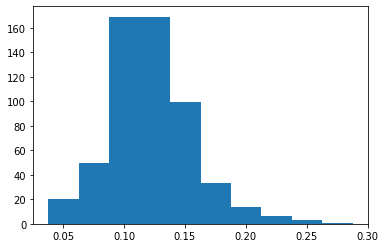

In [77]:
plt.hist(dex_jbar_SIMPLE[(i>30)&(HI==0)])
print('SIMPLISTIC j_bar median error = +/-',np.nanmedian(dex_jbar_SIMPLE[(i>30)&(HI==0)]))

In [78]:
sig_Mstar_MH2 = np.sqrt(sig_Mstar**2 + sig_MH2**2)
sig_star      = np.sqrt( (sig_jstar/j_star)**2 + (sig_Mstar_MH2/(M_star+M_H2))**2 ) * (j_star*(M_star+M_H2))
sig_HI        = np.sqrt( (sig_jHI/j_HI)**2 + (sig_MHI/M_HI)**2 ) * (1.35*j_HI*M_HI)
numerator     = (j_star*(M_star+M_H2) + 1.35*j_HI*M_HI)
sig_numerator = np.sqrt( sig_star**2 + sig_HI**2)

sig_jbar     = np.sqrt( (sig_numerator/numerator)**2 + (sig_Mbar/M_bar)**2 ) * j
dex_jbar     = (sig_jbar)/(np.log(10)*j)

<ipython-input-78-53d758863b59>:2: RuntimeWarning: invalid value encountered in true_divide
  sig_star      = np.sqrt( (sig_jstar/j_star)**2 + (sig_Mstar_MH2/(M_star+M_H2))**2 ) * (j_star*(M_star+M_H2))
<ipython-input-78-53d758863b59>:3: RuntimeWarning: invalid value encountered in true_divide
  sig_HI        = np.sqrt( (sig_jHI/j_HI)**2 + (sig_MHI/M_HI)**2 ) * (1.35*j_HI*M_HI)


j_bar median error = +/- 0.13923194678386747


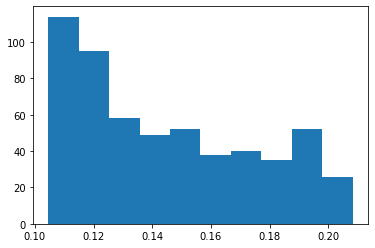

In [79]:
plt.hist(dex_jbar[(i>30)&(HI==0)])
print('j_bar median error = +/-',np.nanmedian(dex_jbar[(i>30)&(HI==0)]))